#Pre-trained DistilRoBERTa for sequence classification

In [2]:
! pip install accelerate torch scikit-learn transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 2.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 10.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import Trainer, TrainingArguments, EvalPrediction
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt

%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
twitter_data = pd.read_csv("data/twitter_dataset_small_w_bart_preds.csv")
twitter_data.head()

,is_positive,id,datetime,user,message,bart_is_positive
0,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...,0.005163
1,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,Young_J,I'm off too bed. I gotta wake up hella early t...,0.339430
2,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,dougnawoschik,I havent been able to listen to it yet My spe...,0.065703
3,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,thireven,now remembers why solving a relatively big equ...,0.004046
4,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,taracollins086,"Ate too much, feel sick",0.000581


In [3]:
# loading a pre-trained model for sequence classification

model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base")

# AutoTokenizer class to automatically select the tokenizer based on the specified architecture ("distilroberta-base")

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# splitting the training and testing data

train_data_pd = twitter_data[["is_positive", "message"]][:1600]
test_data_pd = twitter_data[["is_positive", "message"]][1600:]

print(train_data_pd.shape, test_data_pd.shape)

(1600, 2) (18400, 2)


In [5]:
class TweetData(Dataset):
  def __init__(self, data):
    super().__init__()
    self.data = data

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, i):
    return self.data.iloc[i]

train_data = TweetData(train_data_pd)
test_data = TweetData(test_data_pd)

In [6]:
#tokenizer.batch_encode_plus(list(train_data["message"][:10]), truncation=True, padding=True, max_length=tokenizer.max_len_single_sentence, return_tensors="pt")

In [7]:
# processing the data before feeding it to the model during training or evaluation

def collate_fn(data):
  data = pd.DataFrame(data)
  model_input = tokenizer.batch_encode_plus(list(data["message"]), truncation=True, padding=True, max_length=tokenizer.max_len_single_sentence, return_tensors="pt")
  model_input["labels"] = torch.tensor(list(data["is_positive"]))
  #for k in model_input:
  #  model_input[k] = model_input[k].to(device)
  return model_input

#train_dataloader = DataLoader(train_data, batch_size=32, collate_fn=collate_fn)

In [8]:
def compute_metrics(pred: EvalPrediction):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds,)
  acc = accuracy_score(labels, preds,)
  return {"accuracy": acc, "f1": f1}

In [9]:
trainer = Trainer(model=model, args=TrainingArguments(output_dir="distilroberta-cls", per_device_train_batch_size=32, evaluation_strategy='epoch'), data_collator=collate_fn, train_dataset=train_data, eval_dataset=test_data, compute_metrics=compute_metrics)

In [10]:
trainer.train()

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
out = trainer.predict(test_data)

In [ ]:
roberta_is_positive = torch.sigmoid(torch.tensor(out.predictions[:, 1]))
bart_is_positive = twitter_data[1600:]["bart_is_positive"]

In [ ]:
bart_is_positive


1600     0.001065
1601     0.973015
1602     0.989837
1603     0.002276
1604     0.594086
           ...   
19995    0.886532
19996    0.001541
19997    0.326061
19998    0.881646
19999    0.095757
Name: bart_is_positive, Length: 18400, dtype: float64

In [ ]:
labels = twitter_data[1600:]["is_positive"]
roberta_pr_curve = precision_recall_curve(labels, roberta_is_positive)
bart_pr_curve = precision_recall_curve(labels, bart_is_positive)

In [ ]:
roberta_pr_curve

(array([0.50342391, 0.50345127, 0.50347864, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        2.15912771e-04, 1.07956386e-04, 0.00000000e+00]),
 array([0.00571883, 0.00586382, 0.00590513, ..., 0.9946202 , 0.99466705,
        0.9947314 ], dtype=float32))

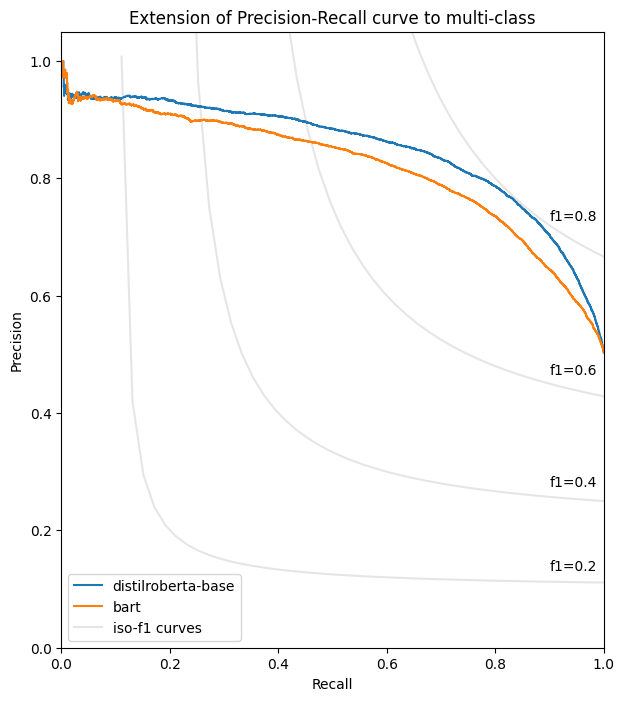

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=roberta_pr_curve[1],
    precision=roberta_pr_curve[0],
)
display.plot(ax=ax, name="distilroberta-base")

display = PrecisionRecallDisplay(
    recall=bart_pr_curve[1],
    precision=bart_pr_curve[0],
)
display.plot(ax=ax, name="bart")

_ = display.ax_.set_title("Precision-Recall curve")

handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()
